# Task 3: Correlation between News Sentiment and Stock Movement

In this notebook, we perform sentiment analysis on news headlines and correlate the daily sentiment scores with daily stock returns.

In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Add src to path
sys.path.append(os.path.abspath(os.path.join('../')))

from src.indicators import load_stock_data
from src.sentiment import analyze_sentiment
from src.correlation import align_dates, calculate_daily_returns, calculate_correlation

In [2]:
# Load News Data
news_path = '../Data/raw_analyst_ratings.csv'
if not os.path.exists(news_path):
    print(f"News data file not found at {news_path}.")
else:
    news_df = pd.read_csv(news_path)
    # Standardize column names
    news_df.columns = [c.lower() for c in news_df.columns]
    # Ensure date column exists and is datetime
    if 'date' in news_df.columns:
        news_df['date'] = pd.to_datetime(news_df['date'], format='ISO8601')
        # Rename to 'Date' for consistency with stock data
        news_df.rename(columns={'date': 'Date'}, inplace=True)
    
    print(news_df.head())

   unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                       Date stock  
0 2020-06-05 10:30:54-04:00     A  
1 2020-06-03 10:45:20-04:00     A  
2 2020-05-26 04:30:07-04:00     

In [3]:
# Filter news for a specific stock (e.g., AAPL)
target_stock = 'AAPL'
if 'news_df' in locals():
    stock_news = news_df[news_df['stock'] == target_stock].copy()
    print(f"Found {len(stock_news)} articles for {target_stock}")

Found 441 articles for AAPL


In [4]:
# Sentiment Analysis
if 'stock_news' in locals() and not stock_news.empty:
    stock_news['sentiment'] = stock_news['headline'].apply(analyze_sentiment)
    
    # Aggregate by day
    daily_sentiment = stock_news.groupby(stock_news['Date'].dt.date)['sentiment'].mean()
    daily_sentiment.index = pd.to_datetime(daily_sentiment.index)
    
    print(daily_sentiment.head())

Date
2020-03-09   -0.155556
2020-03-10    0.021708
2020-03-11    0.018624
2020-03-12   -0.083048
2020-03-13    0.069215
Name: sentiment, dtype: float64


In [5]:
# Load Stock Data
stock_path = f'../Data/Data/{target_stock}.csv'
if os.path.exists(stock_path):
    stock_df = load_stock_data(stock_path)
    daily_returns = calculate_daily_returns(stock_df)
    print(daily_returns.head())

Date
2009-01-02         NaN
2009-01-05    0.042204
2009-01-06   -0.016494
2009-01-07   -0.021609
2009-01-08    0.018570
Name: Close, dtype: float64


Pearson Correlation: 0.1581
P-value: 0.2235


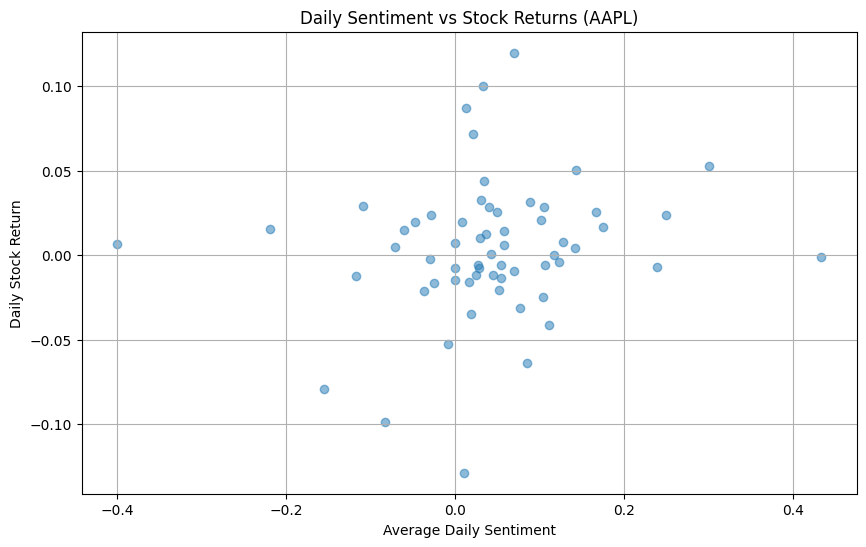

In [6]:
# Correlation Analysis
if 'daily_sentiment' in locals() and 'daily_returns' in locals():
    corr, p_val = calculate_correlation(daily_sentiment, daily_returns)
    print(f"Pearson Correlation: {corr:.4f}")
    print(f"P-value: {p_val:.4f}")
    
    # Visualize
    aligned_data = pd.concat([daily_sentiment, daily_returns], axis=1, join='inner').dropna()
    aligned_data.columns = ['Sentiment', 'Returns']
    
    plt.figure(figsize=(10, 6))
    plt.scatter(aligned_data['Sentiment'], aligned_data['Returns'], alpha=0.5)
    plt.title(f'Daily Sentiment vs Stock Returns ({target_stock})')
    plt.xlabel('Average Daily Sentiment')
    plt.ylabel('Daily Stock Return')
    plt.grid(True)
    plt.show()